# Link learning sandbox

This notebook iteratively learns a **monotone** log-link function 
for expected goals. The link is fit only on the training window 
but team parameters are updated on the full timeline.

Notes:
- The link family is a spline with a *hard monotonicity constraint* on f'(eta).
- f(0)=0 and f'(0)=1 are enforced by construction (same basis as in `Model`).
- Link fitting uses a Poisson marginal likelihood on goals (fast + stable).


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import cProfile, pstats, io
from scipy.optimize import minimize, LinearConstraint

def dr(df):
    with pd.option_context('display.max_rows', None):
        display(df)
        
def dc(df):
    with pd.option_context('display.max_columns', None):
        display(df)
        
def drc(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
dcr = drc

from src.model import Model, MAX_LOG_EXP

RESULTS_PATH = "match_results/results_clean.csv"

TRAIN_START_YEAR = 1950
TRAIN_END_YEAR = 2000
EVAL_START_YEAR = 2001
EVAL_END_YEAR = 2010

SUBSAMPLE_RATE = 1

LINK_K = 12
LINK_ETA_MIN = -6.0
LINK_ETA_MAX =  6.0
LINK_TAU = 10.0
LINK_DEGREE = 3
LINK_CLAMP = True
LINK_LOOKUP_GRID = 2049

MIN_SLOPE = 0.01
SLOPE_GRID = max(50, 4 * LINK_K)
GOAL_CAP = None  # set to 10 if you want to cap extreme scores for link fitting

EPOCHS = 20
PROFILE_EPOCHS = True
PROFILE_EVERY = EPOCHS

MODEL_KWARGS = dict(
    maintain_param_history=False,
    recenter_params=True,
    variance_per_year=0.2,
    rho=0.1,
    hga=0.2,
    hga_prior_var=5e-3,
    hga_rw_var_per_year=1e-3,
)
from src.link_spline import LinkFunctionSpline


In [82]:
results = (
    pd.read_csv(RESULTS_PATH, parse_dates=["date"])
    .sort_values("date")
    .reset_index(drop=True)
)
results["year"] = results["date"].dt.year
results.head()


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,shootout_first_shooter,home_confederation,away_confederation,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,NaN,NaN,UEFA,UEFA,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,NaN,NaN,UEFA,UEFA,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,NaN,NaN,UEFA,UEFA,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,NaN,NaN,UEFA,UEFA,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,NaN,NaN,UEFA,UEFA,1876


In [83]:
def build_penalty(k: int) -> np.ndarray:
    penalty = np.zeros((k, k), dtype=float)
    if k >= 3:
        D = np.zeros((k - 2, k), dtype=float)
        for i in range(k - 2):
            D[i, i] = 1.0
            D[i, i + 1] = -2.0
            D[i, i + 2] = 1.0
        penalty = D.T @ D
    penalty = penalty + np.eye(k)
    return penalty


def build_link() -> LinkFunctionSpline:
    return LinkFunctionSpline(
        k=LINK_K,
        eta_min=LINK_ETA_MIN,
        eta_max=LINK_ETA_MAX,
        degree=LINK_DEGREE,
        clamp=LINK_CLAMP,
    )


def basis_matrix(link: LinkFunctionSpline, eta: np.ndarray):
    phi = np.zeros((len(eta), link.k), dtype=float)
    phi_prime = np.zeros((len(eta), link.k), dtype=float)
    for i, e in enumerate(eta):
        p, pp = link.basis_values(float(e))
        phi[i] = p
        phi_prime[i] = pp
    return phi, phi_prime


def fit_link_beta(
    eta: np.ndarray,
    goals: np.ndarray,
    beta0: np.ndarray,
    link: LinkFunctionSpline,
    penalty: np.ndarray,
    tau: float,
    min_slope: float,
    slope_grid: int,
):
    mask = np.isfinite(eta) & np.isfinite(goals)
    eta = np.asarray(eta[mask], dtype=float)
    goals = np.asarray(goals[mask], dtype=float)
    if GOAL_CAP is not None:
        goals = np.minimum(goals, GOAL_CAP)
    phi, _ = basis_matrix(link, eta)

    grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, slope_grid)
    _, phi_prime_grid = basis_matrix(link, grid)
    A = phi_prime_grid
    lb = (min_slope - 1.0) * np.ones(A.shape[0])
    constraint = LinearConstraint(A, lb, np.inf)

    penalty_scaled = penalty / (tau ** 2)

    def loss(beta):
        f = eta + phi @ beta
        mu = np.exp(np.clip(f, -MAX_LOG_EXP, MAX_LOG_EXP))
        reg = 0.5 * beta.T @ penalty_scaled @ beta
        return float(mu.sum() - np.dot(goals, f) + reg)

    def grad(beta):
        f = eta + phi @ beta
        mu = np.exp(np.clip(f, -MAX_LOG_EXP, MAX_LOG_EXP))
        return phi.T @ (mu - goals) + penalty_scaled @ beta

    res = minimize(
        loss,
        x0=beta0,
        jac=grad,
        method="trust-constr",
        constraints=[constraint],
        options={"maxiter": 200, "verbose": 1},
    )
    return res.x, res


def link_eval(beta: np.ndarray, link: LinkFunctionSpline, eta: np.ndarray):
    phi, phi_prime = basis_matrix(link, eta)
    f = np.zeros_like(eta, dtype=float)
    fprime = np.zeros_like(eta, dtype=float)
    for i, x in enumerate(eta):
        if x <= LINK_ETA_MIN:
            phi_min, _ = link.basis_values(float(LINK_ETA_MIN))
            f[i] = float(LINK_ETA_MIN + np.dot(beta, phi_min))
            fprime[i] = 0.0
        elif x >= LINK_ETA_MAX:
            phi_max, _ = link.basis_values(float(LINK_ETA_MAX))
            f[i] = float(LINK_ETA_MAX + np.dot(beta, phi_max))
            fprime[i] = 0.0
        else:
            f[i] = float(x + np.dot(beta, phi[i]))
            fprime[i] = float(1.0 + np.dot(beta, phi_prime[i]))
    return f, fprime

def prepare_link_data(res: pd.DataFrame, start_year: int, end_year: int):
    df = res[(res["year"] >= start_year) & (res["year"] <= end_year)]
    eta = np.concatenate([df["eta_home_pre"].values, df["eta_away_pre"].values])
    goals = np.concatenate([df["home_score"].values, df["away_score"].values])
    return eta, goals


def run_model(beta: np.ndarray, results: pd.DataFrame):
    grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, LINK_LOOKUP_GRID)
    phi_grid, phi_prime_grid = basis_matrix(link, grid)
    f_grid = grid + phi_grid @ beta
    fprime_grid = 1.0 + phi_prime_grid @ beta

    f_min = float(f_grid[0])
    f_max = float(f_grid[-1])

    def link_func(x):
        x = float(x)
        if x <= LINK_ETA_MIN:
            return f_min
        if x >= LINK_ETA_MAX:
            return f_max
        return float(np.interp(x, grid, f_grid))

    def link_func_deriv(x):
        x = float(x)
        if x <= LINK_ETA_MIN or x >= LINK_ETA_MAX:
            return 0.0
        return float(np.interp(x, grid, fprime_grid))

    model = Model(
        link_func=link_func,
        link_func_deriv=link_func_deriv,
        **MODEL_KWARGS,
    )
    res = model.fit(results)
    return model, res


In [84]:
link = build_link()
penalty = build_penalty(LINK_K)

beta = np.zeros(LINK_K, dtype=float)
history = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch} ===")
    do_profile = PROFILE_EPOCHS and (epoch % PROFILE_EVERY == 0)
    if do_profile:
        pr = cProfile.Profile()
        pr.enable()
        t0 = time.time()
    model, res = run_model(beta, results.iloc[::SUBSAMPLE_RATE])
    eta_train, goals_train = prepare_link_data(res, TRAIN_START_YEAR, TRAIN_END_YEAR)
    beta_new, opt = fit_link_beta(
        eta_train,
        goals_train,
        beta,
        link,
        penalty,
        LINK_TAU,
        MIN_SLOPE,
        SLOPE_GRID,
    )
    if do_profile:
        pr.disable()
        elapsed = time.time() - t0
        s = io.StringIO()
        ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime")
        ps.print_stats(20)
        print(s.getvalue())
        print(f"epoch elapsed {elapsed:.2f}s")
    # add inside the epoch loop, after beta_new is computed
    delta = float(np.linalg.norm(beta_new - beta))
    grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, 201)
    f_grid, fprime_grid = link_eval(beta_new, link, grid)
    print(
        "beta_delta", round(delta, 6),
        "fprime_min", round(fprime_grid.min(), 3),
        "fprime_max", round(fprime_grid.max(), 3),
        "f(-3)", round(f_grid[np.argmin(np.abs(grid + 3))], 3),
        "f(-2)", round(f_grid[np.argmin(np.abs(grid + 2))], 3),
    )

    grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, 201)
    _f, _fprime = link_eval(beta_new, link, grid)
    summary = {
        "epoch": epoch,
        "opt_status": str(opt.message),
        "fprime_min": float(np.min(_fprime)),
        "fprime_max": float(np.max(_fprime)),
    }
    print(summary)
    history.append(summary)
    beta = beta_new



=== Epoch 1 ===
`xtol` termination condition is satisfied.
Number of iterations: 193, function evaluations: 220, CG iterations: 1232, optimality: 3.45e-06, constraint violation: 0.00e+00, execution time: 0.38 s.
beta_delta 4.862759 fprime_min -0.024 fprime_max 4.497 f(-3) -2.849 f(-2) -0.9
{'epoch': 1, 'opt_status': '`xtol` termination condition is satisfied.', 'fprime_min': -0.024218915239318406, 'fprime_max': 4.49718521182711}

=== Epoch 2 ===
The maximum number of function evaluations is exceeded.
Number of iterations: 200, function evaluations: 195, CG iterations: 1754, optimality: 8.28e-05, constraint violation: 0.00e+00, execution time: 0.34 s.
beta_delta 8.309831 fprime_min -0.048 fprime_max 7.017 f(-3) -2.043 f(-2) -0.775
{'epoch': 2, 'opt_status': 'The maximum number of function evaluations is exceeded.', 'fprime_min': -0.048499480731873046, 'fprime_max': 7.017040496220117}

=== Epoch 3 ===
The maximum number of function evaluations is exceeded.
Number of iterations: 200, fun

In [85]:
model, res = run_model(beta, results)
res.head()


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,...,dlogp_df_away_pre,home_games_played,away_games_played,p_home,p_draw,p_away,p_result,p_score,loss_result,loss_score
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,NaN,...,-0.739567,1,1,0.450205,0.311584,0.238212,0.311584,0.141020,1.061418,1.958856
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,NaN,...,1.256137,2,2,0.300391,0.463868,0.235741,0.300391,0.000425,1.094718,7.764397
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,NaN,...,-0.907745,3,3,0.405567,0.222713,0.371720,0.405567,0.077007,0.821462,2.563857
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,NaN,...,0.317794,4,4,0.361852,0.249183,0.388965,0.249183,0.067525,1.264840,2.695259
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,NaN,...,-1.491106,5,5,0.530865,0.220221,0.248914,0.530865,0.042642,0.576407,3.154924


In [86]:
def tail_diag(res, side, start_year, end_year, q=10):
    R = res[(res["year"] >= start_year) & (res["year"] <= end_year)].copy()
    R = R[(R["home_games_played"] >= 10) & (R["away_games_played"] >= 10)]
    eta_col = f"eta_{side}_pre"
    exp_col = f"exp_{side}_score"
    score_col = f"{side}_score"
    R["bin"] = pd.qcut(R[eta_col].round(3), q=q, duplicates="drop")
    out = (
        R.groupby("bin")[[score_col, exp_col]]
        .agg(["mean", "count"])
        .round(3)
    )
    print(out.head(3))  # left tail
    return out

display(tail_diag(res, "home", 2001, 2010, q=10))
display(tail_diag(res, "away", 2001, 2010, q=10))

                             home_score       exp_home_score      
                                   mean count           mean count
bin                                                               
(-6.098000000000001, -0.785]      0.650   876          0.461   876
(-0.785, -0.306]                  0.978   880          0.641   880
(-0.306, -0.024]                  1.078   871          0.861   871


/var/folders/y9/7mrfwwc97kg93k2qmfccslvm0000gn/T/ipykernel_80105/1099797453.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  R.groupby("bin")[[score_col, exp_col]]


home_score       exp_home_score      
                                   mean count           mean count
bin                                                               
(-6.098000000000001, -0.785]      0.650   876          0.461   876
(-0.785, -0.306]                  0.978   880          0.641   880
(-0.306, -0.024]                  1.078   871          0.861   871
(-0.024, 0.222]                   1.230   875          1.106   875
(0.222, 0.457]                    1.344   878          1.397   878
(0.457, 0.68]                     1.485   875          1.666   875
(0.68, 0.94]                      1.701   873          1.903   873
(0.94, 1.308]                     1.891   875          2.067   875
(1.308, 2.041]                    2.273   875          2.132   875
(2.041, 9.796]                    3.710   876          3.069   876

                 away_score       exp_away_score      
                       mean count           mean count
bin                                                   
(-6.545, -1.564]      0.412   876          0.379   876
(-1.564, -1.045]      0.629   877          0.506   877
(-1.045, -0.727]      0.761   874          0.532   874


/var/folders/y9/7mrfwwc97kg93k2qmfccslvm0000gn/T/ipykernel_80105/1099797453.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  R.groupby("bin")[[score_col, exp_col]]


away_score       exp_away_score      
                       mean count           mean count
bin                                                   
(-6.545, -1.564]      0.412   876          0.379   876
(-1.564, -1.045]      0.629   877          0.506   877
(-1.045, -0.727]      0.761   874          0.532   874
(-0.727, -0.474]      0.785   876          0.599   876
(-0.474, -0.238]      0.960   874          0.718   874
(-0.238, -0.001]      0.960   881          0.890   881
(-0.001, 0.254]       1.162   872          1.133   872
(0.254, 0.571]        1.199   875          1.471   875
(0.571, 1.172]        1.541   873          1.907   873
(1.172, 8.118]        2.445   876          2.485   876

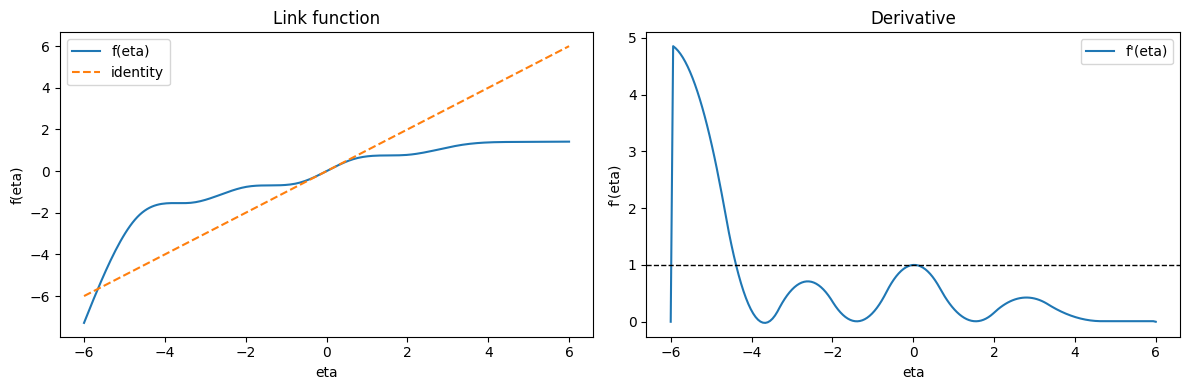

In [87]:
grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, 201)
f_grid, fprime_grid = link_eval(beta, link, grid)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(grid, f_grid, label="f(eta)")
axs[0].plot(grid, grid, "--", label="identity")
axs[0].set_title("Link function")
axs[0].set_xlabel("eta")
axs[0].set_ylabel("f(eta)")
axs[0].legend()

axs[1].plot(grid, fprime_grid, label="f'(eta)")
# axs[1].set_ylim(0, 5 * MIN_SLOPE)
axs[1].axhline(1.0, color="black", linestyle="--", linewidth=1)
axs[1].set_title("Derivative")
axs[1].set_xlabel("eta")
axs[1].set_ylabel("f'(eta)")
axs[1].legend()

plt.tight_layout()
plt.show()


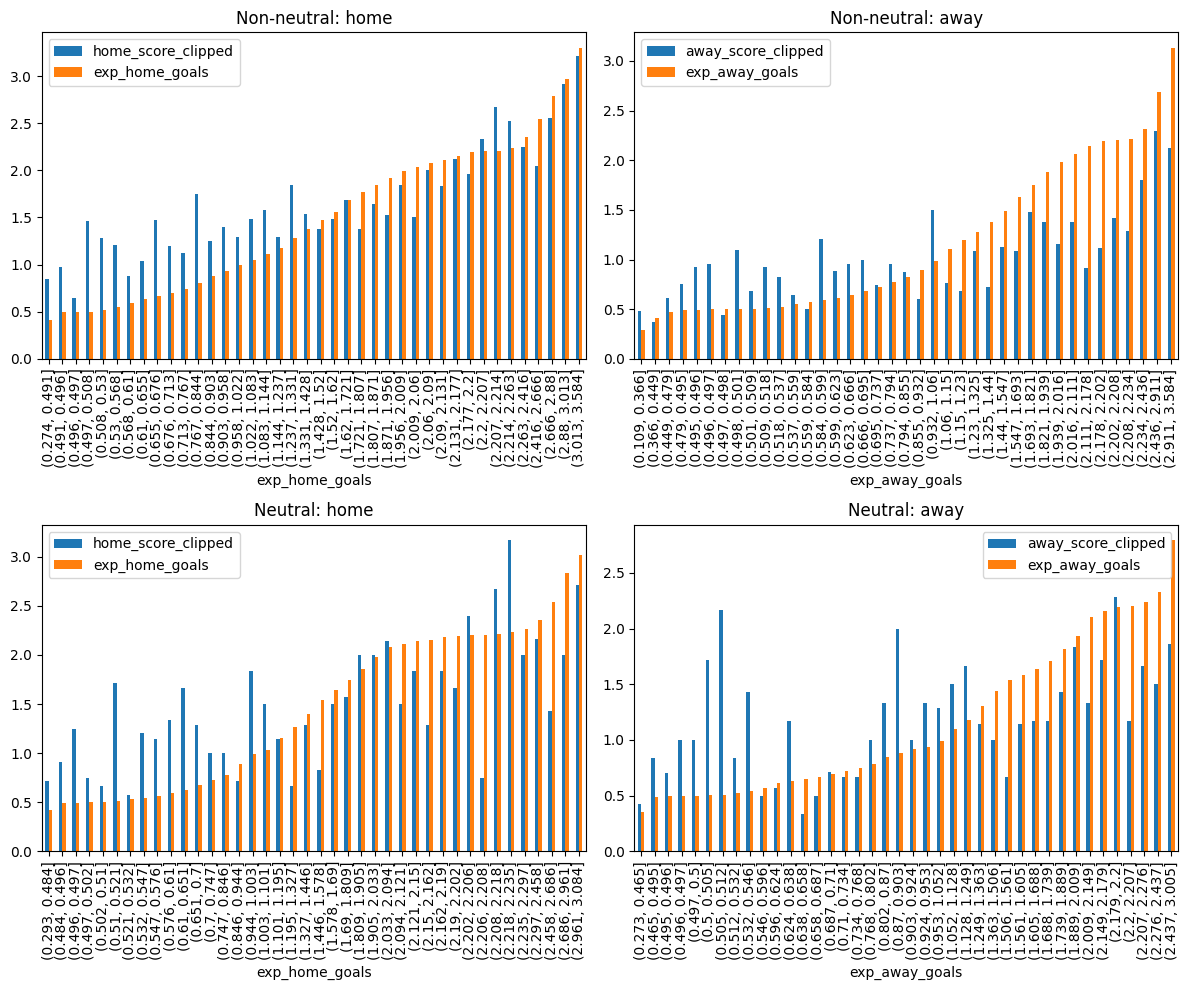

log mean abs error (home/away): -1.013 -0.895


In [79]:
def calibration_plots(res, start_year, end_year, q=20, min_games=10, mode="means", use_corr=False):
    R = res[(res["year"] >= start_year) & (res["year"] <= end_year)].copy()
    if min_games is not None:
        R = R[(R["home_games_played"] >= min_games) & (R["away_games_played"] >= min_games)]
    R["total_score"] = R["home_score"] + R["away_score"]
    R["exp_total_score"] = R["exp_home_score"] + R["exp_away_score"]

    R["home_score_clipped"] = R["home_score"].clip(0, np.inf)
    R["away_score_clipped"] = R["away_score"].clip(0, np.inf)
    R["total_score_clipped"] = R["home_score_clipped"] + R["away_score_clipped"]

    if use_corr:
        R["var_eta_home"] = R["home_sigma_attack_pre"] + R["away_sigma_defense_pre"]
        R["var_eta_away"] = R["away_sigma_attack_pre"] + R["home_sigma_defense_pre"]
        R["exp_home_score_corr"] = np.exp(
            R["f_home_pre"] + 0.5 * (R["fprime_home_pre"] ** 2) * R["var_eta_home"]
        )
        R["exp_away_score_corr"] = np.exp(
            R["f_away_pre"] + 0.5 * (R["fprime_away_pre"] ** 2) * R["var_eta_away"]
        )

    exp_home_col = "exp_home_score_corr" if use_corr else "exp_home_score"
    exp_away_col = "exp_away_score_corr" if use_corr else "exp_away_score"

    def _binned_stats(df, exp_col, actual_col):
        bins = pd.qcut(df[exp_col].round(3), q=q, duplicates="drop")
        stats = df.groupby(bins, observed=False)[[actual_col, exp_col]].mean()
        stats["resid"] = stats[actual_col] - stats[exp_col]
        stats["exp_mean"] = stats[exp_col]
        return stats

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    non = R.query("~neutral")
    neu = R.query("neutral")

    if mode == "resid":
        plots = [
            (non, exp_home_col, "home_score_clipped", "Non-neutral: home"),
            (non, exp_away_col, "away_score_clipped", "Non-neutral: away"),
            (neu, exp_home_col, "home_score_clipped", "Neutral: home"),
            (neu, exp_away_col, "away_score_clipped", "Neutral: away"),
        ]
        for ax, (df, exp_col, actual_col, title) in zip(axs, plots):
            stats = _binned_stats(df, exp_col, actual_col)
            ax.plot(stats["exp_mean"], stats["resid"], marker="o")
            ax.axhline(0.0, color="black", linewidth=1)
            ax.set_title(title)
            ax.set_xlabel("mean expected goals")
            ax.set_ylabel("mean residual (actual - expected)")
    else:
        (
            _binned_stats(non, exp_home_col, "home_score_clipped")[["home_score_clipped", exp_home_col]]
        ).plot.bar(ax=axs[0], title="Non-neutral: home")
        (
            _binned_stats(non, exp_away_col, "away_score_clipped")[["away_score_clipped", exp_away_col]]
        ).plot.bar(ax=axs[1], title="Non-neutral: away")
        (
            _binned_stats(neu, exp_home_col, "home_score_clipped")[["home_score_clipped", exp_home_col]]
        ).plot.bar(ax=axs[2], title="Neutral: home")
        (
            _binned_stats(neu, exp_away_col, "away_score_clipped")[["away_score_clipped", exp_away_col]]
        ).plot.bar(ax=axs[3], title="Neutral: away")

    plt.tight_layout()
    plt.show()

    home_score = (
        _binned_stats(R, exp_home_col, "home_score_clipped")
        .eval("L = abs(home_score_clipped - {col})".format(col=exp_home_col))
        .L.mean()
    )
    away_score = (
        _binned_stats(R, exp_away_col, "away_score_clipped")
        .eval("L = abs(away_score_clipped - {col})".format(col=exp_away_col))
        .L.mean()
    )
    print("log mean abs error (home/away):", round(np.log(home_score), 3), round(np.log(away_score), 3))


calibration_plots(res, TRAIN_START_YEAR, TRAIN_END_YEAR, q=40, min_games=10, mode="means", use_corr=False)


## Export a hardcoded link

This exports `eta_grid` and `f_grid` for a monotone interpolation (e.g. PCHIP)
that you can paste into `model.py`.


In [ ]:
eta_grid = np.linspace(LINK_ETA_MIN, LINK_ETA_MAX, 401)
f_grid, fprime_grid = link_eval(beta, link, eta_grid)
print("eta_grid =", np.round(eta_grid, 6).tolist())
print("f_grid =", np.round(f_grid, 6).tolist())
